In [1]:
from qutip import *
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

N = 8
times = np.linspace(0.0, 10.0, 200)

psi_list = [basis(2, 1) for i in range(N)]
#psi_list = [basis(2, 0 if i == N // 2 else 1) for i in range(N)]
#psi_list = [basis(2, (i+1) % 2) for i in range(N)]
psi0 = tensor(psi_list)

hx, hy = 0.0, 0.0
Jx, Jy, Jz = 1.0, 0.0, 0.0
hz = 1.0 #[(np.random.uniform(-8.0, 8.0) + 4) / 2 for _ in range(N)] #[3.5002456640243587, 2.1348410418662898, 3.7939020763471074, 1.8076311318070069, 4.6941678763876196, 1.16944650425613]
gamma = 0.001
alpha = 3 #1.13

In [2]:
sx_list = []
sy_list = []
sz_list = []
sm_list = []

for n in range(N):
    op_list = [qeye(2) for _ in range(N)]
    
    op_list[n] = sigmax()
    sx_list.append(tensor(op_list))
    
    op_list[n] = sigmay()
    sy_list.append(tensor(op_list))
    
    op_list[n] = sigmaz()
    sz_list.append(tensor(op_list))
    
    op_list[n] = destroy(2)
    sm_list.append(tensor(op_list))

H = 0
for n in range(N):
    H += hx * sx_list[n]
    H += hy * sy_list[n]
    H += hz * sz_list[n]

l = N
for i in range(N):
    for j in range(i+1, min(i+1+l, N)):
        H += Jx / (np.abs(i-j)**alpha) * sx_list[i] * sx_list[j]
        H += Jy / (np.abs(i-j)**alpha) * sy_list[i] * sy_list[j]
        H += Jz / (np.abs(i-j)**alpha) * sz_list[i] * sz_list[j]

c_op_list = [np.sqrt(gamma) * sm_list[k] for k in range(N)]

total_sz = sum(sz_list)

result = mesolve(H, psi0, times, c_op_list, e_ops=sz_list + [total_sz], options={"progress_bar" : "tqdm", "store_states" : True})
#result = sesolve(H, psi0, times, e_ops=sz_list + [total_sz], options={"progress_bar" : "tqdm"})

  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
corr_zz = np.zeros((len(times), N, N), dtype=np.complex128)

for i in tqdm(range(N), unit="i"):
    for j in range(N):
        corr = correlation_2op_2t(H, psi0, [0], times, c_op_list, sz_list[i], sz_list[j])
        corr_zz[:,i,j] = corr

D = 0.5 * (1 - N**(-1) * np.trace(corr_zz, axis1=1, axis2=2)).real

In [4]:
states = result.states
left_n  = N // 2
keep    = list(range(left_n))

entropy_list = []

for psi_t in states:
    rho_t = ket2dm(psi_t) if psi_t.isket else psi_t

    rho_left = rho_t.ptrace(keep)

    S = entropy_vn(rho_left, base=2)

    entropy_list.append(S)

In [5]:
states = result.states
keep = [1, 5]

mutual_information = []

for psi_t in states:
    rho_t = ket2dm(psi_t) if psi_t.isket else psi_t

    rho_1 = rho_t.ptrace(keep[0:1])
    rho_2 = rho_t.ptrace(keep[1:])
    rho_12 = rho_t.ptrace(keep)

    S1 = entropy_vn(rho_1, base=2)
    S2 = entropy_vn(rho_2, base=2)
    S12 = entropy_vn(rho_12, base=2)

    mutual_information.append(S1+S2-S12)

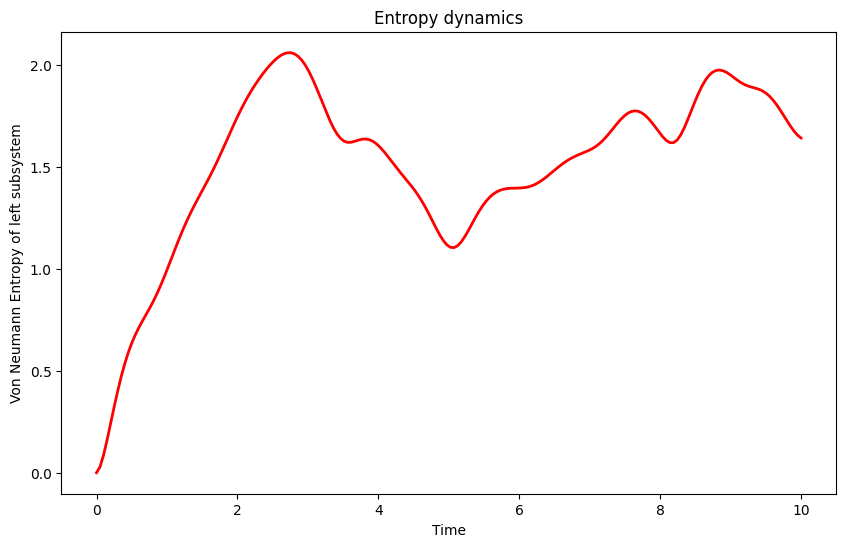

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(times, entropy_list, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Von Neumann Entropy of left subsystem')
plt.title('Entropy dynamics')
plt.show()

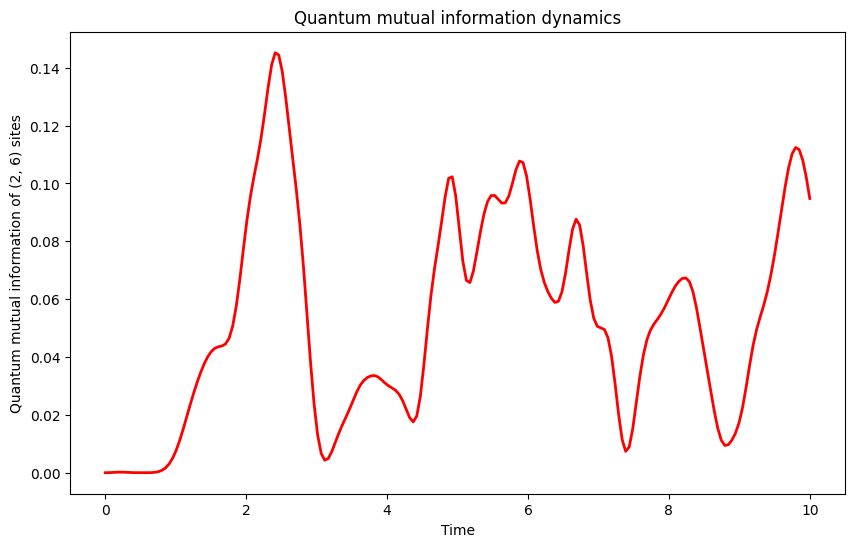

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(times, mutual_information, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(f'Quantum mutual information of ({keep[0]+1}, {keep[1]+1}) sites')
plt.title('Quantum mutual information dynamics')
plt.show()

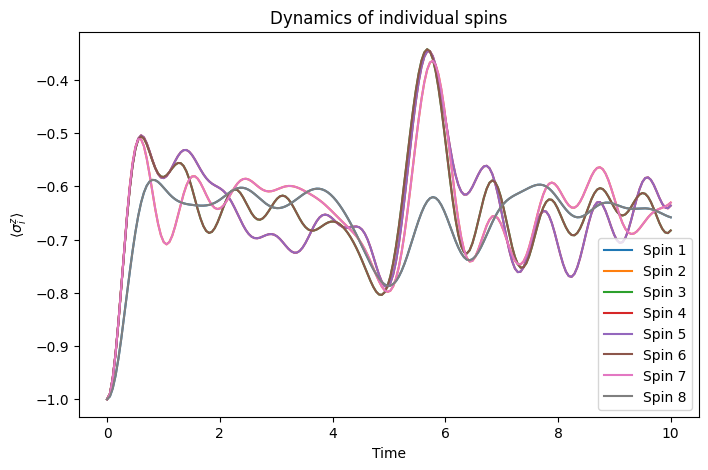

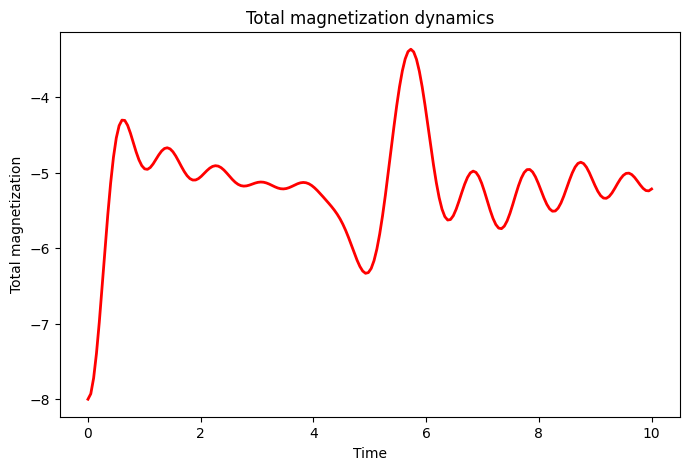

In [41]:
plt.figure(figsize=(8, 5))
for n in range(N):
    plt.plot(times, result.expect[n], label=f"Spin {n+1}")
plt.xlabel('Time')
plt.ylabel(r'$⟨σ^z_i⟩$')
plt.legend()
plt.title('Dynamics of individual spins')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, result.expect[N], 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total magnetization')
plt.title('Total magnetization dynamics')
plt.show()

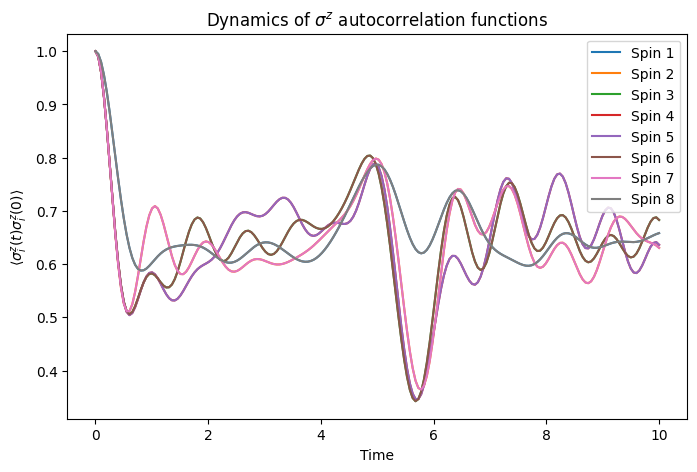

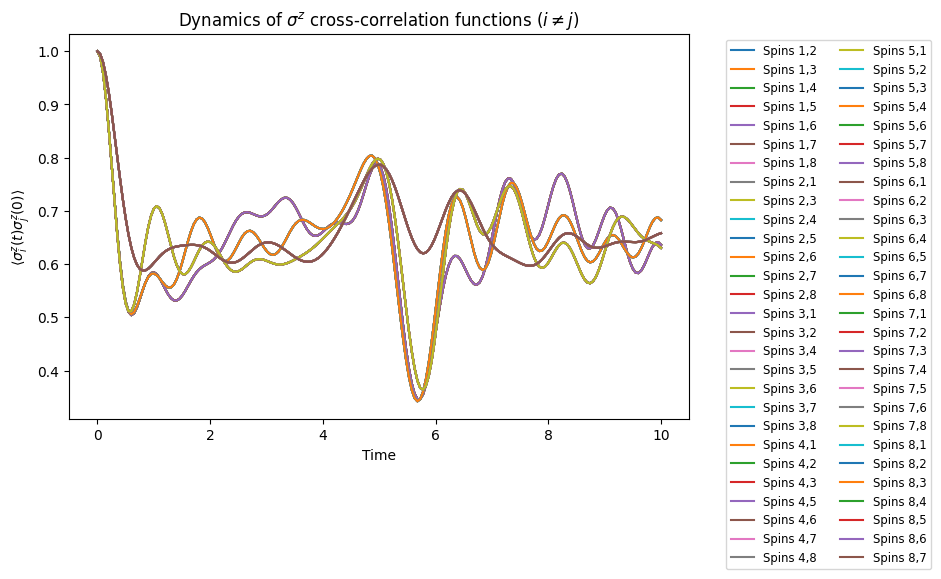

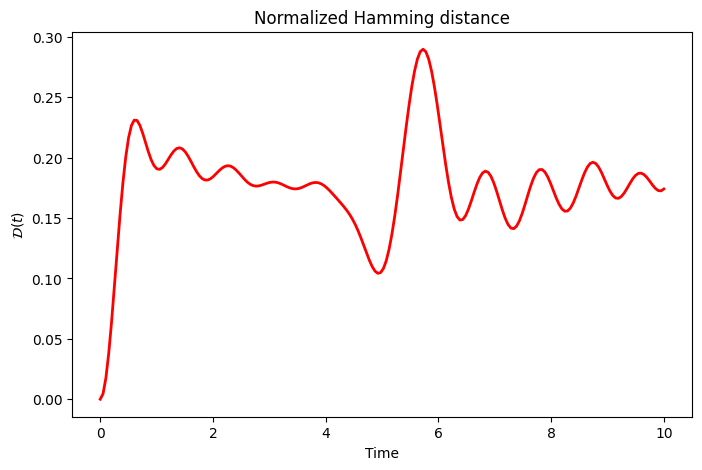

In [43]:
plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(times, np.real(corr_zz[:, i, i]), label=f'Spin {i+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma^z_i(t)\sigma^z_i(0) \rangle$')
plt.legend()
plt.title(r'Dynamics of $\sigma^z$ autocorrelation functions')
plt.show()

plt.figure(figsize=(8, 5))
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(times, np.real(corr_zz[:, i, j]), label=f'Spins {i+1},{j+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma^z_i(t)\sigma^z_j(0) \rangle$')
plt.title(r'Dynamics of $\sigma^z$ cross-correlation functions ($i \neq j$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, D, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'$\mathcal{D}(t)$')
plt.title('Normalized Hamming distance')
plt.show()